In [20]:
# Standard IPython notebook imports
%matplotlib inline

import os

import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz
import httpimport
import scipy.stats as sstats
import sklearn.ensemble
import sklearn.tree

In [4]:
df = pd.read_csv('data/responses.csv')
df = df.fillna(-1.0)
df.shape

(1010, 150)

In [6]:
target_ID = 74

In [7]:
df[df.columns[target_ID]]

0          drink a lot
1          drink a lot
2          drink a lot
3          drink a lot
4       social drinker
             ...      
1005       drink a lot
1006    social drinker
1007    social drinker
1008    social drinker
1009    social drinker
Name: Alcohol, Length: 1010, dtype: object

In [5]:
df

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,...,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,1.0,2.0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,5.0,3.0,...,4.0,3.0,4.0,3.0,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,1.0,4.0,5.0,1.0,4.0,3.0,2.0,3.0,4.0,3.0,few hours a day,3.0,4.0,5.0,3.0,3.0,1,3.0,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0,5.0,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,1.0,4.0,1.0,3.0,4.0,5.0,2.0,4.0,4.0,5.0,1.0,...,4.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,5.0,3.0,4.0,5.0,3.0,2.0,3.0,few hours a day,3.0,4.0,1.0,4.0,2.0,5,2.0,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0,5.0,3.0,4.0,4.0,2.0,4.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,2.0,1.0,5.0,2.0,4.0,2.0,4.0,1.0,...,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,3.0,1.0,few hours a day,2.0,4.0,1.0,4.0,3.0,4,2.0,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,1.0,5.0,4.0,4.0,3.0,3.0,4.0,3.0,1.0,2.0,5.0,1.0,2.0,4.0,4.0,5.0,4.0,1.0,3.0,1.0,2.0,3.0,...,1.0,5.0,3.0,1.0,3.0,3.0,2.0,5.0,5.0,4.0,5.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,-1.0,2.0,4.0,most of the day,2.0,4.0,3.0,3.0,4.0,4,1.0,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,5.0,2.0,3.0,3.0,4.0,4.0,3.0,1.0,4.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,...,4.0,2.0,3.0,3.0,3.0,3.0,5.0,4.0,2.0,3.0,5.0,5.0,2.0,3.0,5.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0,few hours a day,4.0,3.0,4.0,3.0,3.0,2,4.0,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,2.0,4.0,1.0,5.0,4.0,4.0,3.0,3.0,2.0,5.0,2.0,3.0,4.0,5.0,4.0,2.0,5.0,5.0,2.0,1.0,4.0,4.0,4.0,2.0,1.0,2.0,4.0,3.0,1.0,2.0,...,4.0,3.0,4.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,5.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,3.0,few hours a day,3.0,5.0,4.0,3.0,4.0,3,4.0,20.0,164.0,57.0,1.0,female,right handed,secondary school,no,city,house/bungalow
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0,1.0,2.0,3.0,1.0,3.0,4.0,1.0,5.0,2.0,5.0,5.0,1.0,5.0,5.0,1.0,5.0,5.0,2.0,5.0,4.0,1.0,1.0,5.0,4.0,5.0,5.0,2.0,2.0,...,5.0,1.0,3.0,3.0,3.0,5.0,5.0,4.0,1.0,2.0,5.0,1.0,1.0,4.0,4.0,3.0,5.0,3.0,1.0,3.0,4.0,3.0,less than an hour a day,3.0,1.0,1.0,1.0,1.0,5,3.0,27.0,183.0,80.0,5.0,male,left handed,m

In [8]:
def entropy(counts):
    s = sum(counts)
    counts = counts / s
    return -np.sum(counts * np.log2(counts + 1e-100))

def gini(counts):
    s = sum(counts)
    counts = counts / s
    return 1 - np.sum(counts * counts)

def mean_err_rate(counts):
    counts = counts / sum(counts)
    return 1 - max(counts)

In [11]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """
    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

In [26]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        attr = self.attr
        assert(attr in x)
        if x[attr] in self.subtrees:
            return self.subtrees[x[attr]]
        
        return None

    def iter_subtrees(self):
        return self.subtrees.values()
    
    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f'{id(parent)}', f'{id(child)}',
                     label=f'{split_name}')

In [24]:
def get_categorical_split_and_purity(df, parent_purity, purity_fun, attr,
                                     normalize_by_split_entropy=False):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    # parent purity - weighted sum of children purity
    
    children_purity = 0
    for group_name, group_df in df.groupby(attr):
        children_purity += purity_fun(group_df['target'].value_counts()) * len(group_df)
    children_purity /= len(df)
    
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - children_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [22]:
def get_split(df, criterion="infogain", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # 1. Node is pure
    target_value_counts = df['target'].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    possible_splits = list(df.keys()) #done
    possible_splits.remove('target') 
    assert "target" not in possible_splits
    #    Terminate early if none are possivle
    if not possible_splits:
        return None
    
    # Get the base purity measure and the purity function
    if criterion in ['infogain', 'infogain_ratio']:
        purity_fun = entropy
    elif criterion in ['mean_err_rate']:    
        purity_fun = mean_err_rate
    elif criterion in ['gini']:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    # if nattrs is not None:
    #     possible_splits = TODO
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner 
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity
        
        split, purity_gain = split_sel_fun(
            df, base_purity, purity_fun, attr,
            normalize_by_split_entropy=criterion.endswith('ratio'))
        
        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

In [9]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values, 
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()
        
        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if 'all_targets' not in kwargs:
            kwargs['all_targets'] = sorted(df['target'].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)
        
        # Get kwargs we know about, remaning ones are for splitting
        self.all_targets = kwargs.pop('all_targets')
        
        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df['target'].value_counts()
        self.info = {
            'num_samples': len(df),
            'entropy': entropy(self.counts),
            'gini': gini(self.counts),
        }
        
        self.split = get_split(df, **kwargs)
        if self.split:
            #print('!!S', self.split)
            self.split.build_subtrees(df, kwargs_orig)
    
    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            # TODO: descend into subtrees and return the leaf target distribution
            subtree = self.split(sample)
            if subtree is None:
                return self.counts
            else:
                return subtree.get_target_distribution(sample)
                
    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        if self.split is None:
            return self.counts.idxmax()
        else:
            subtree = self.split(sample)
            if subtree is None:
                return self.counts.idxmax()
            else:
                return subtree.classify(sample)


    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f'{c}:{freq:.2f}')
        colors = ':'.join(colors)
        labels = [' '.join(freqs_info)]
        if print_info:
            for k,v in self.info.items():
                labels.append(f'{k} = {v}')
        if self.split:
            labels.append(f'split by: {self.split.attr}')
        dot.node(f'{id(self)}',
                 label='\n'.join(labels), 
                 shape='box',
                 style='striped',
                 fillcolor=colors,
                 colorscheme='set19')
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)
            
    def upper_confidenct_interval(self, f, N, z=0.5):
        return (f + ((z ** 2) / (2 * N)) \
                + z * ((f / N - (f ** 2) / N + z ** 2 / (4 * (N ** 2))) ** 0.5))  \
                / (1 + (z ** 2) / N)

    def prune_with_confidence_interval(self):
        if self.split:
            for w in self.split.iter_subtrees():
                w.prune_with_confidence_interval()
        
        N = self.info['num_samples']
        parent_error = self.counts / np.sum(self.counts)
        parent_error = sorted(list(parent_error), reverse=True)
        parent_error = np.sum(parent_error[1:])
        parent_error = self.upper_confidenct_interval(parent_error, N)
        self.info['confidence_error'] = parent_error
        
        if self.split:
            children_error = 0
            for w in self.split.iter_subtrees():
                child_error = (w.info['num_samples'] / N) * w.info['confidence_error']
                children_error += child_error
     
        
            if children_error > parent_error:
                self.split = None
                self.info['splitted'] = True

In [12]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th
    
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs))

    def __call__(self, x):
        if x[self.attr] <= self.th:
            return self.subtrees[0]
        else:
            return self.subtrees[1]
    
    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees
    
    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[0])}',
                 label=f'<= {self.th:.2f}')
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[1])}',
                 label=f'> {self.th:.2f}')

In [13]:
def get_numrical_split_and_purity(df, parent_purity, purity_fun, attr,
                                  normalize_by_split_entropy=False):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, 'target']].sort_values(attr)
    targets = attr_df['target']
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0

        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)

        # the loop should return the best possible split.

        # TODO: update left_counts and right_counts
        right_counts[row_target] -= 1
        left_counts[row_target] -= 1
        
        # The split is possible if attribute_value != next_attribute_value
        if attribute_value == next_attribute_value:
            continue

        
        if attr_df.iloc[row_i][0] != attr_df.iloc[row_i + 1][0]:
            children_purity = (row_i + 1) * purity_fun(left_counts) \
                                + (N - row_i - 1) * purity_fun(right_counts)
            children_purity /= N
            purity = parent_purity - children_purity

            if purity > best_purity_gain:
                best_purity_gain = purity
                attr_mean = (attr_df.iloc[row_i][0] + attr_df.iloc[row_i + 1][0]) / 2
                best_split = NumericalSplit(attr, attr_mean)

    if normalize_by_split_entropy:
        best_purity_gain /= entropy(targets.value_counts())
    # TODO: now consider the split at split_threshold and save it if it the best one
    return best_split, best_purity_gain

In [125]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
alco2d = df.copy() #iris_df[['petal_length', 'petal_width', 'target']]
alco2d['target'] = df[df.columns[target_ID]]
alco2d['target'] = alco2d['target'].replace(['never', 'social drinker', 'drink a lot'], [1, 3, 5])

In [126]:
alco2d = alco2d.drop(columns = alco2d.columns[target_ID])

In [127]:
alco2d = alco2d.dropna()
alco2d = alco2d.reset_index(drop=True)

In [128]:
for colmn in alco2d.columns:
   alco2d = alco2d[alco2d[colmn]!=-1]

In [129]:
alco2d = alco2d.reset_index(drop=True)

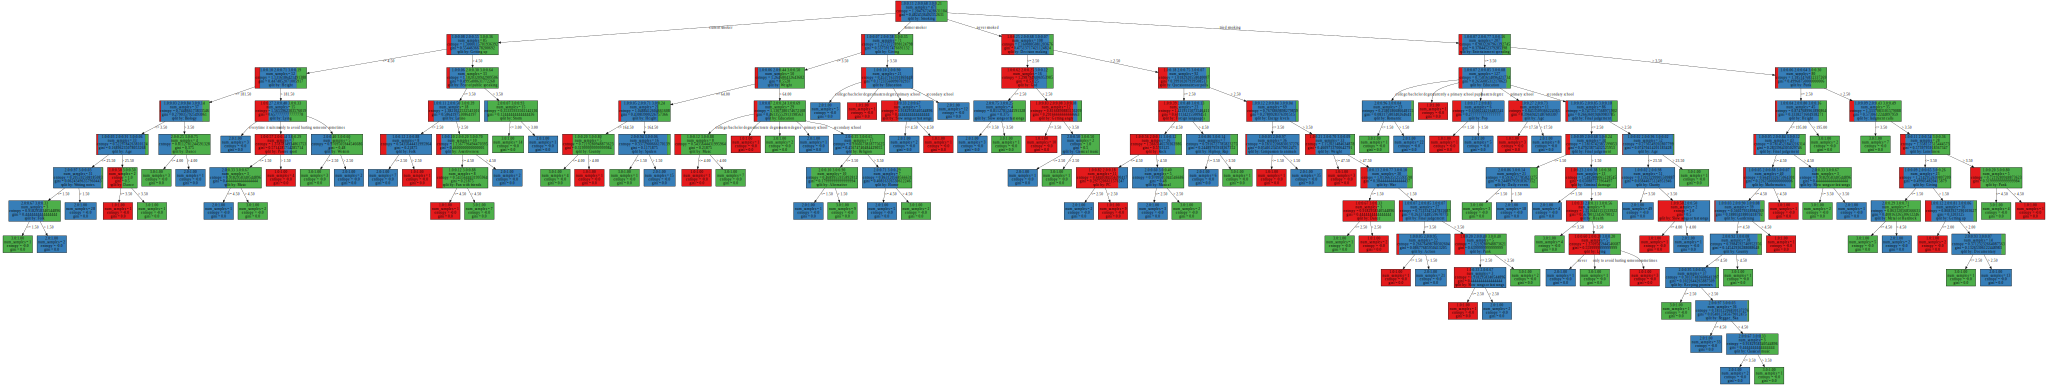

In [73]:
train_alco_df, test_alco_df = train_test_split(alco2d, test_size=0.3)
alco_tree = Tree(train_alco_df, criterion='gini')
alco_tree.draw()

In [74]:
# compute error
not_prunned_targets = []
for i in range(len(test_alco_df)):
    not_prunned_targets.append(alco_tree.classify(test_alco_df.iloc[i]))

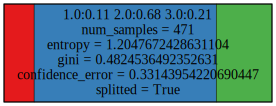

In [77]:
alco_tree_0 = alco_tree
alco_tree_0.prune_with_confidence_interval()
# compute error
prunned_targets = []
for i in range(len(test_alco_df)):
    prunned_targets.append(alco_tree.classify(test_alco_df.iloc[i]))
alco_tree.draw()

In [79]:
# compare errors
print('Classification for not_prunned tree:')
not_prunned_class = pd.Series(
                    np.array(test_alco_df['target']) == np.array(not_prunned_targets)
                    ).value_counts()
print(not_prunned_class)
print(f'Not prunned error: {not_prunned_class[False] / len(test_alco_df) * 100:.3f}%')

print()
prunned_class = pd.Series(
                        np.array(test_alco_df['target']) == np.array(prunned_targets)
                        ).value_counts()
print(prunned_class)
print(f'Prunned error: {prunned_class[False] / len(test_alco_df) * 100:.3f}%')

Classification for not_prunned tree:
True     110
False     93
dtype: int64
Not prunned error: 45.813%

True     128
False     75
dtype: int64
Prunned error: 36.946%


In [130]:
alcohol = pd.get_dummies(alco2d)

In [142]:
alcohol['target']

0      5.0
1      5.0
2      5.0
3      3.0
4      1.0
      ... 
669    3.0
670    5.0
671    3.0
672    3.0
673    3.0
Name: target, Length: 674, dtype: float64

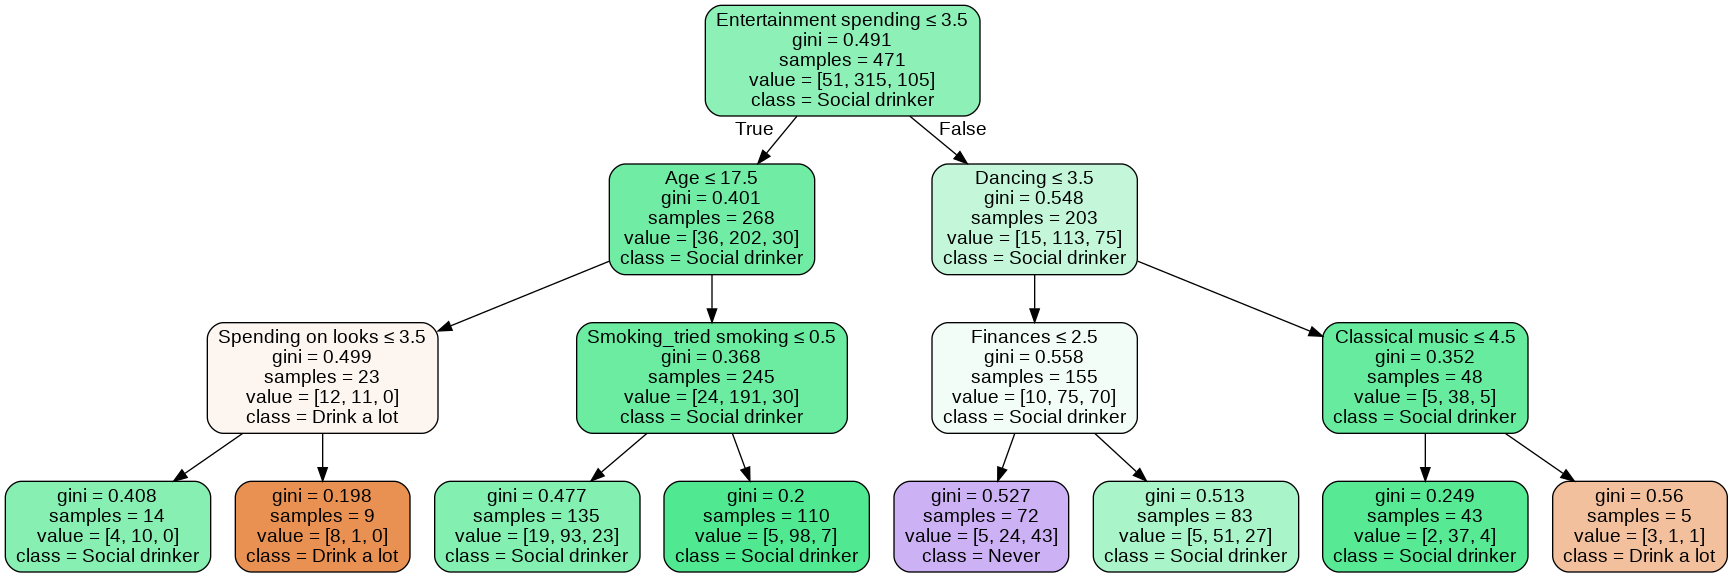

In [150]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
X_train, X_test, y_train, y_test = train_test_split(alcohol.drop('target',axis=1), alcohol['target'], test_size=.3, random_state=22)
X_train.shape, X_test.shape

#developing a model
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz

# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

xvar = alcohol.drop('target', axis=1)
feature_cols = xvar.columns

dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Drink a lot','Social drinker','Never'])

from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Old data (not prunned, not trained, not properly dropped NaN values).

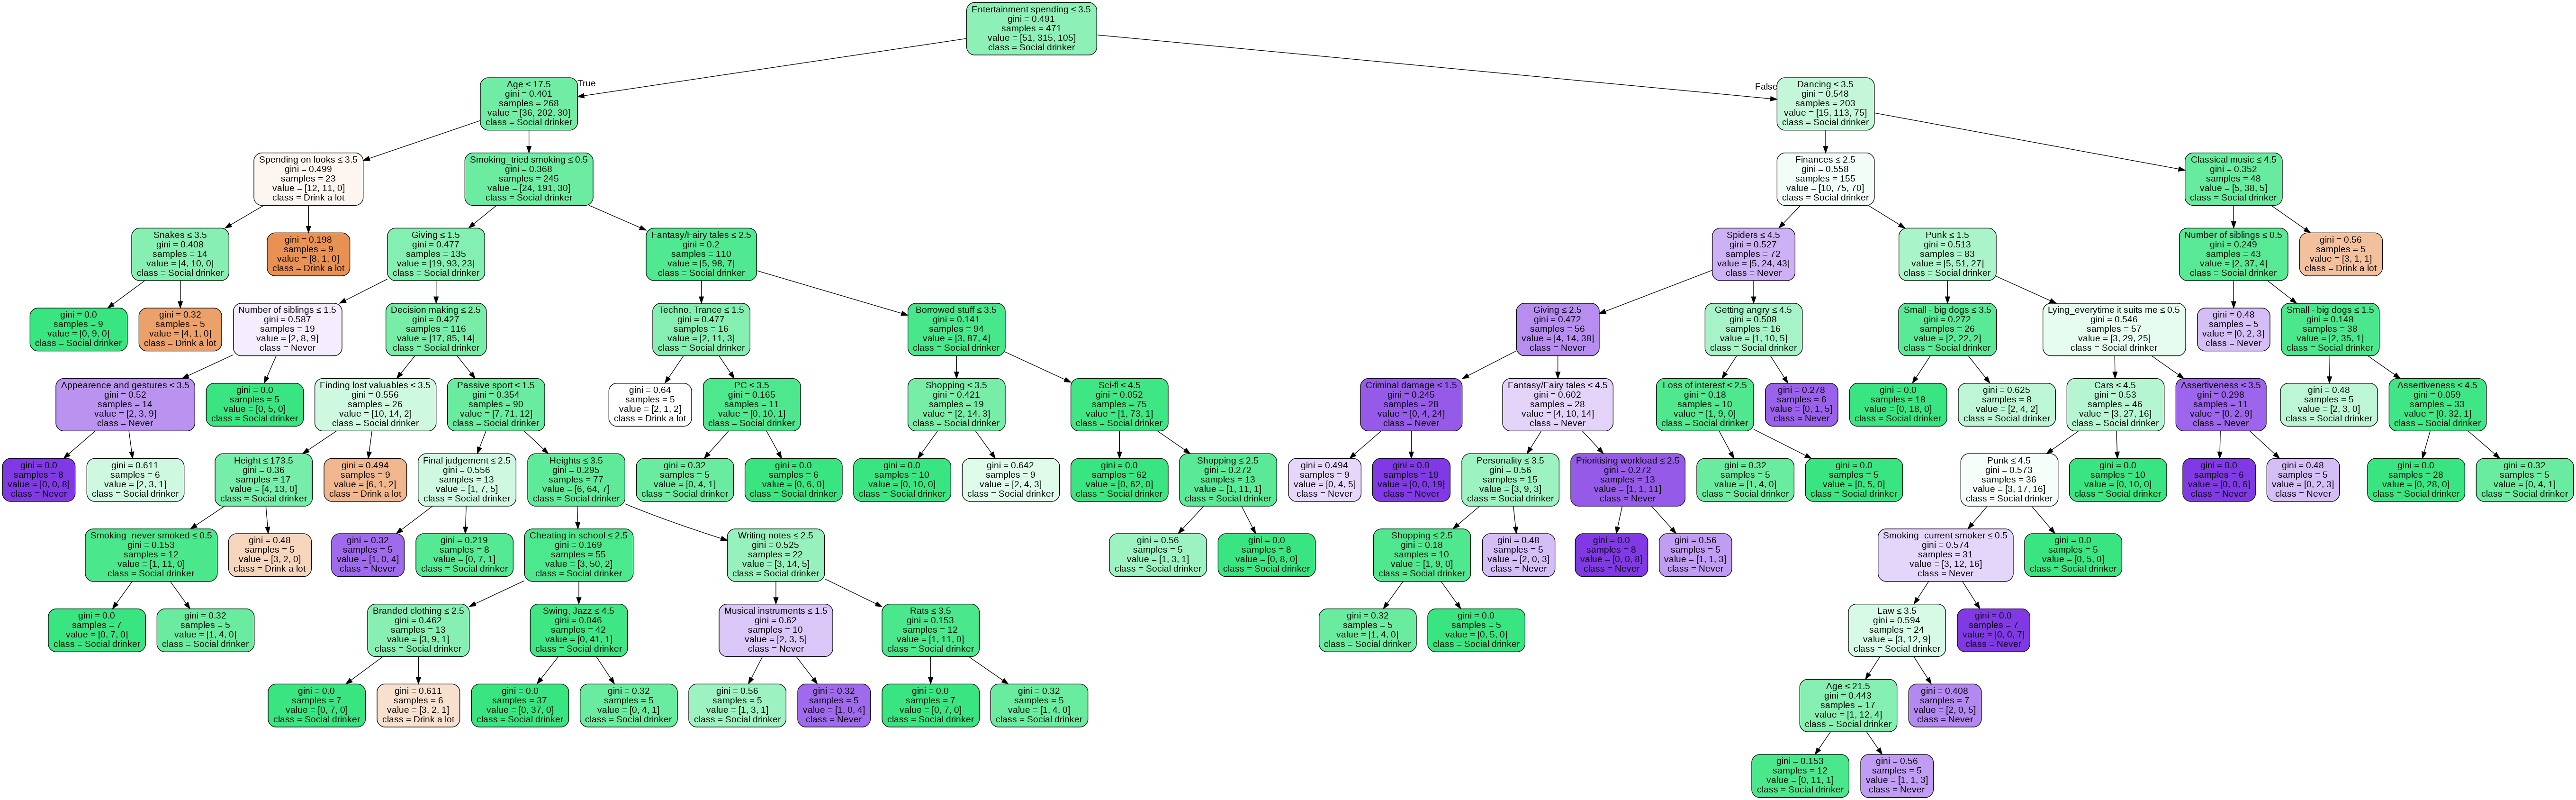

In [ ]:
Image(graph.create_png())

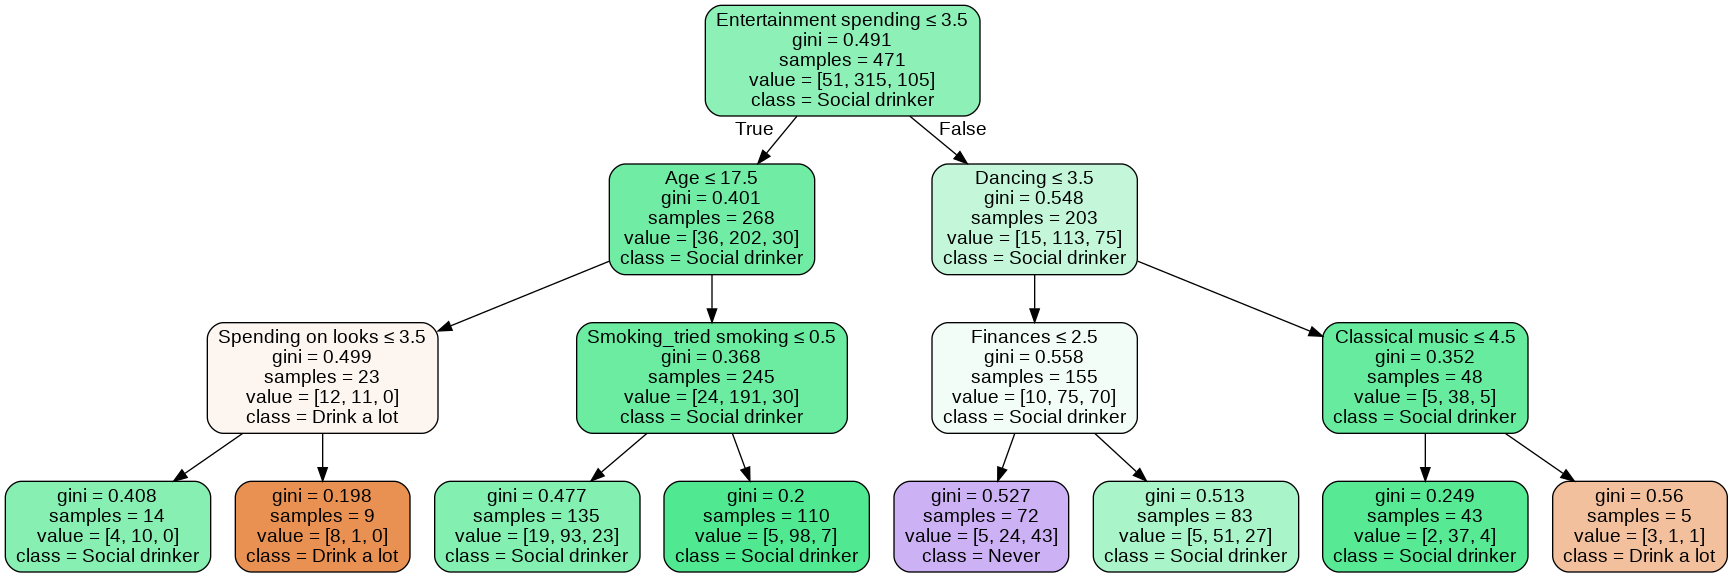

In [ ]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
X_train, X_test, y_train, y_test = train_test_split(alcohol.drop('target',axis=1), alcohol['target'], test_size=.3, random_state=22)
X_train.shape, X_test.shape

#developing a model
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz

# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

xvar = alcohol.drop('target', axis=1)
feature_cols = xvar.columns

dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['Drink a lot','Social drinker','Never'])

from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

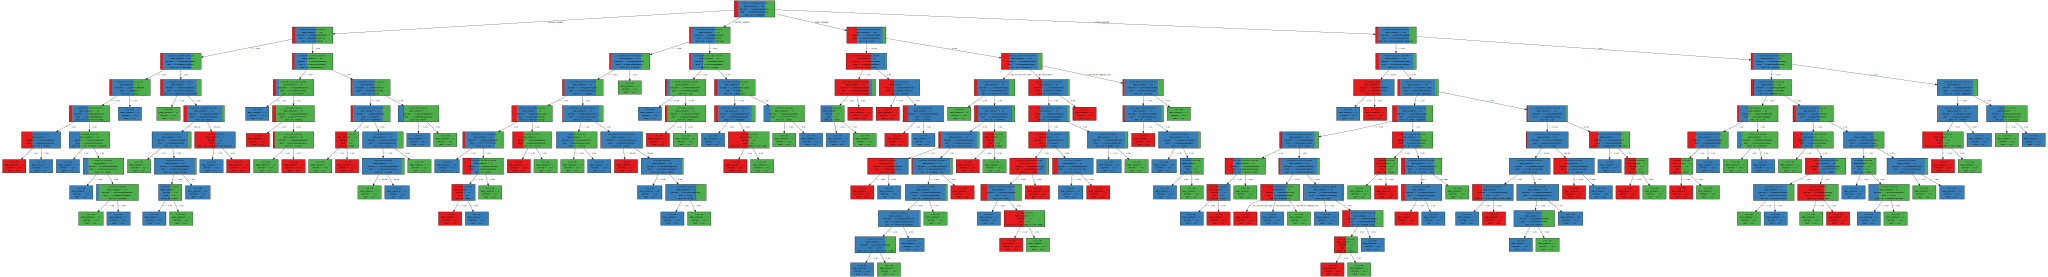

In [ ]:
alco_tree = Tree(alco2d, criterion='gini')
alco_tree.draw()

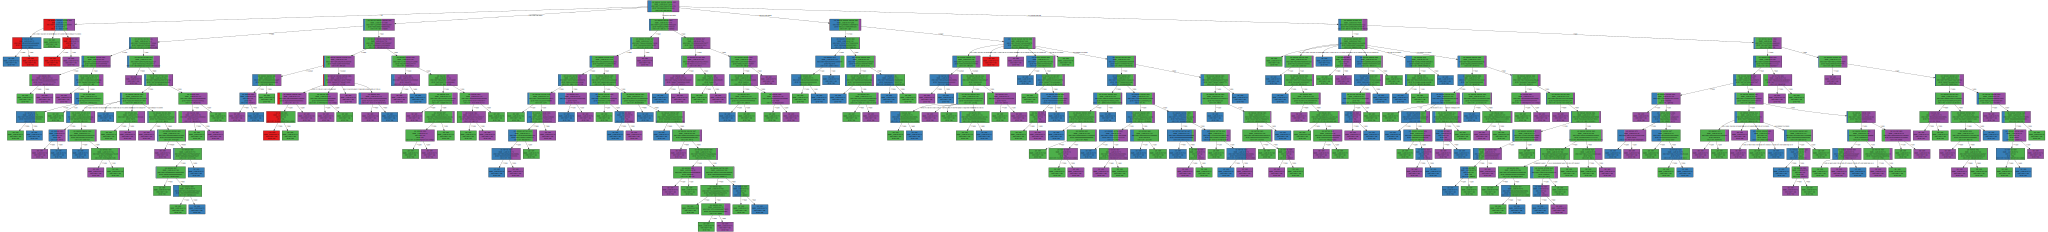

In [ ]:
alco_tree = Tree(alco2d, criterion='gini')
alco_tree.draw()